In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time

In [2]:
Gamma = 22 # MHz, Decay rate
k = 1/359.3*1e9*2*np.pi #x_0
x0 = 1/k # meter
t0 = 1/Gamma*1/(2*np.pi*1e6) # second
v0 = x0/t0 # m/s
m0 = cts.hbar*t0/x0**2 # kg
a0 = x0/t0**2 # m/s^2
F0 = cts.hbar/(x0*t0) # kg*m/s^2
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
mag_field_grad = 1000*x0 #G/m
v_max = 4
z_max = 20/x0*1e-3 # meter
z_start = 20/x0*1e-3
dz = 0.5  
dv = 0.5
v_eval = np.arange(1.0,4.0,0.4)
t_eval = np.linspace(0.,4000000.,4000001)
wavelength = 359.3e-9
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
dets = np.array([-0.25, -0.5, -1, -2])
P = np.array([0.010, 0.050, 0.1, 0.2])
intensities = 2.*P/(np.pi*0.012**2)/Isat
power_index = 1


H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=2.4/Gamma, q=0, p=0,gJ = -0.0002*2,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [16]:
def Fixed_detune_MgF_MOT(s):
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.15,pol=+1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=s, delta=(E_A[-1] - Eg_i)-0.5, pol=-1,wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [27]:
laserBeams = Fixed_detune_MgF_MOT(intensities[power_index])

In [28]:
laserBeams.intensity(R=np.array([1e10,1e10,waist]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [29]:
zz = np.linspace(-1*z_max,z_max+dz,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

laserBeams = Fixed_detune_MgF_MOT(intensities[power_index])
magField = pylcp.quadrupoleMagneticField(mag_field_grad)
rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

In [30]:
rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=1)

Completed in 11.81 s.                                               


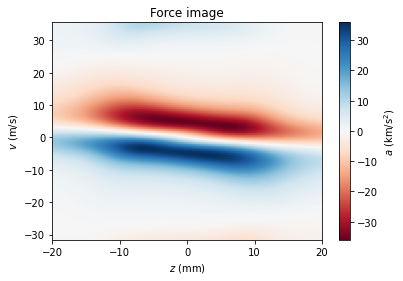

In [31]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
           extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                   (np.amin(vv*v0)), (np.amax(vv*v0))),
           aspect='auto',cmap='RdBu')
cb1 = plt.colorbar()
cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Force image')
fig.subplots_adjust(left=0.12,right=0.9)

# fig.savefig('./picture/50mW_force_z.png')

In [8]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=5e-2):
    if y[-4]<threshold:
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=4):
    if y[-4]>threshold:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True
conditions =  [captured_condition,lost_condition]

In [9]:
sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 4.64 s.                                                   
Completed in 4.66 s.                                                   
Completed in 4.72 s.                                                   
Completed in 5.35 s.                                                   
Completed in 5.16 s.                                                   
Completed in 4.87 s.                                                   
Completed in 0.83 s.                                                   
Completed in 0.73 s.                                                   


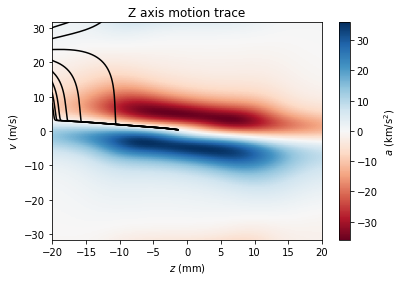

In [10]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
           extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                   (np.amin(vv*v0)), (np.amax(vv*v0))),
           aspect='auto',cmap='RdBu')
cb1 = plt.colorbar()
cb1.set_label('$a\ (\mathrm{km/s^2})$')
ax.set_xlabel('$z\ (\mathrm{mm})$')
ax.set_ylabel('$v\ (\mathrm{m/s})$')
ax.set_title('Z axis motion trace')
ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
ax.set_ylim(-1*v_max*v0,v_max*v0)
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2]*x0*1000,sol.v[2]*v0, 'k')

fig.savefig('./picture/50mW_motion_z.png')

In [10]:
start = time.time()

In [11]:
# for sol in sols_rate:
#     if len(sol.t_events[0])==1:
#         print('trapped')
#     elif len(sol.t_events[1])==1:
#         print('lost')
#     else:
#         print('i don`t know')

In [19]:
def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=np.inf, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
    if isinstance(eqn,pylcp.rateeq):
        eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step,method='LSODA')
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

ValueError: f(a) and f(b) must have different signs

In [ ]:
print(time.time()-start)

-3.941607067580896e-11


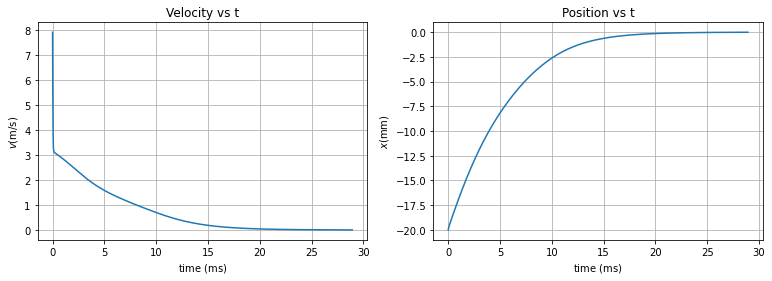

In [15]:
sols = sols_rate[0]
fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[2]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[2]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])

fig.savefig('./picture/50mW_trap_z.png')

3.6260034836325555e-12


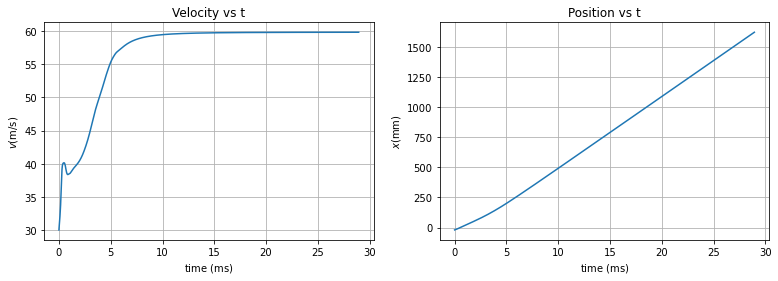

In [16]:
sols = sols_rate[-1]
fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].set_title('Velocity vs t')
ax[1].set_title('Position vs t')

ax[0].plot(sols.t*t0*1000,sols.v[2]*v0)
ax[1].plot(sols.t*t0*1000,sols.r[2]*1000*x0)

ax[0].set_ylabel('$v (\mathrm{m/s})$')
ax[0].set_xlabel('time $(\mathrm{ms})$')
ax[1].set_ylabel('$x (\mathrm{mm})$')
ax[1].set_xlabel('time $(\mathrm{ms})$')

for i in range(2):
    ax[i].grid()
    
print(sols.v[0][-1])
fig.savefig('./picture/50mW_lost_z.png')